
### 1. **Problema:**
   - **Objetivo:** Prever a quantidade total de defeitos e os tipos de defeitos associados a cada ordem de produção com base nas medidas do frasco (peso, comprimento, diâmetro).
   
   - **Desafio:** A previsão de defeitos não é trivial, pois não há uma correlação direta óbvia entre as medidas do frasco e o total de defeitos. 
   
   - **Impacto:** A capacidade de prever defeitos com antecedência pode permitir que a produção seja ajustada antes de erros significativos ocorrerem, ajudando a reduzir perdas e melhorar a eficiência operacional.

### 2. **Solução:**
   A solução para o problema será dividida em três objetivos principais:

   #### Objetivo 1: **Prever a Quantidade Total de Defeitos**
   - Utilização de técnicas de **regressão** (Random Forest) para prever o número total de defeitos em uma ordem de produção com base nas medidas de produção.
   
   - **Variáveis de entrada (X):** Peso médio (g), Comprimento médio (mm), Diâmetro.
   
   - **Variável alvo (y):** Total de Defeitos no Dia.

   #### Objetivo 2: **Prever a Temperatura Recomendada**
   - Baseado nos dias com menor número de defeitos, será criado um modelo para prever a temperatura que minimiza a quantidade de defeitos.
   
   - **Variáveis de entrada (X):** Peso médio (g), Comprimento médio (mm), Diâmetro.
   
   - **Variável alvo (y):** Temperatura (F°), de forma que a produção ocorra de forma otimizada.

### 3. **Métodos e Abordagem:**
   A solução para os objetivos será baseada em um modelo de aprendizado de máquina, utilizando **Random Forest** e **Gradient Boosting** para prever tanto o total de defeitos quanto os tipos de defeitos associados.

   #### Preprocessamento dos Dados:
   - **Escalonamento dos Dados:** As medidas de produção serão normalizadas (usando `StandardScaler` ou `MinMaxScaler`) para garantir que todas as variáveis entrem no modelo com a mesma escala.
   
   - **Divisão dos Dados:** Será feita a divisão entre dados de treino e teste (80/20), garantindo a validação adequada do modelo.
   
   - **Tratamento de Defeitos Críticos vs. Não Críticos:** Classificação dos defeitos para determinar quais defeitos podem ser mais críticos, o que ajudará na priorização de correções durante a produção.

### 4. **Resultados Esperados:**
   - **Previsão de Defeitos Totais:** A partir das medidas do frasco, seremos capazes de prever a quantidade total de defeitos que ocorrerão em uma ordem de produção, ajudando a antecipar perdas.
   
   - **Previsão de Temperatura Ideal:** Será possível prever a temperatura que resulta em uma produção de qualidade, minimizando defeitos.
   
   - **Previsão de Tipos de Defeitos Específicos:** A solução também preverá os tipos de defeitos mais prováveis de ocorrer, proporcionando informações detalhadas 
   sobre as causas e possíveis ações corretivas.

### 5. **Benefícios da Solução:**
   - **Redução de Perdas:** Com previsões mais precisas de defeitos, a produção pode ser ajustada antecipadamente para evitar a fabricação de produtos com defeitos.
   
   - **Melhoria na Eficiência Operacional:** Identificando os tipos de defeitos críticos, será possível tomar ações corretivas mais focadas, melhorando a produtividade geral.
   
   - **Otimização das Condições de Produção:** A previsão da temperatura ideal ajudará a otimizar o processo, reduzindo falhas de produção e mantendo a qualidade.

### 6. **Próximos Passos:**
   - Implementar e testar os modelos de previsão para cada um dos objetivos, ajustando os hiperparâmetros e avaliando o desempenho.
   - Validar a acurácia do modelo com um conjunto de dados de teste real para garantir que os resultados sejam robustos e confiáveis.
   - Se possível, coletar dados de produção adicionais para refinar os modelos e melhorar sua precisão.



## Implementação do Modelo

### Importando bibliotecas

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

### Importando dataset

In [3]:
dados = pd.read_csv('../dados/medidas_geral_e_defeitos.csv')
df = pd.DataFrame(dados)

In [4]:
df = df.set_index(['Ordem de prod', 'Ref. do Artigo', 'Data de prod'])

In [5]:
df

Temperatura (F°)  Peso médio (g)  \
Ordem de prod Ref. do Artigo Data de prod                                     
192970        C0516.0000R    2024-01-03             2126.97           169.3   
                             2024-01-04             2118.92           169.7   
                             2024-01-05             2125.00           173.6   
                             2024-01-06             2125.40           170.2   
                             2024-01-07             2126.76           171.7   
...                                                     ...             ...   
194121        C0516.0000R    2024-06-26             2154.44           169.0   
                             2024-06-27             2152.32           168.9   
                             2024-06-28             2145.60           169.3   
                             2024-06-29             2145.60           168.8   
                             2024-06-30             2148.00           169.2   

                                           Comprimento médio (mm)  Diâmetro  \
Ordem de prod Ref. do Artigo Data de prod                                     
192970        C0516.0000R    2024-01-03                     110.4      32.5   
                             2024-01-04                      85.6      18.1   
                             2024-01-05                     140.5      32.9   
                             2024-01-06                     144.7      32.7   
                             2024-01-07                     141.5      30.2   
...                                                           ...       ...   
194121        C0516.0000R    2024-06-26                     124.3      32.6   
                             2024-06-27                     120.2      33.6   
                             2024-06-28                     124.1      34.2   
                             2024-06-29                     120.0      33.5   
                             2024-06-30                     122.9      34.6   

                                           Total de Defeitos no Dia  \
Ordem de prod Ref. do Artigo Data de prod                             
192970        C0516.0000R    2024-01-03                         222   
                             2024-01-04                         249   
                             2024-01-05                         268   
                             2024-01-06                         242   
                             2024-01-07                         232   
...                                                             ...   
194121        C0516.0000R    2024-06-26                         258   
                             2024-06-27                         218   
                             2024-06-28                         218   
                             2024-06-29                         213   
                             2024-06-30                         256   

                                          Defeito Mais Frequente do Dia  \
Ordem de prod Ref. do Artigo Data de prod                                 
192970        C0516.0000R    2024-01-03                    Sujo de óleo   
                             2024-01-04                    Sujo de óleo   
                             2024-01-05                    Sujo de óleo   
                             2024-01-06                    Sujo de óleo   
                             2024-01-07                    Sujo de óleo   
...                                                                 ...   
194121        C0516.0000R    2024-06-26                    Sujo de óleo   
                             2024-06-27                    Sujo de óleo   
                             2024-06-28                    Sujo de óleo   
                             2024-06-29                    Sujo de óleo   
                             2024-06-30                    Sujo de óleo   

                                           Sujo de óleo  Rugas  \
Ordem de prod Ref. do

### Verificando se o dataframe está limpo e padronizado

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 200 entries, (192970, 'C0516.0000R', '2024-01-03') to (194121, 'C0516.0000R', '2024-06-30')
Columns: 133 entries, Temperatura (F°) to Crú
dtypes: float64(4), int64(128), object(1)
memory usage: 216.2+ KB


In [7]:
df.isnull().sum()

Temperatura (F°)            0
Peso médio (g)              0
Comprimento médio (mm)      0
Diâmetro                    0
Total de Defeitos no Dia    0
                           ..
Ferrugem no corpo           0
Fagulha                     0
Alça deformada              0
Instabilidade               0
Crú                         0
Length: 133, dtype: int64

In [8]:
df_reset = df.reset_index()

In [9]:
df_reset

,Ordem de prod,Ref. do Artigo,Data de prod,Temperatura (F°),Peso médio (g),Comprimento médio (mm),Diâmetro,Total de Defeitos no Dia,Defeito Mais Frequente do Dia,Sujo de óleo,...,Bolha aberta interna,Cascão cortante,Espessura abaixo do mínimo,Fundo deformado,Bolha na alça,Ferrugem no corpo,Fagulha,Alça deformada,Instabilidade,Crú
0,192970,C0516.0000R,2024-01-03,2126.97,169.3,110.4,32.5,222,Sujo de óleo,31,...,0,0,0,0,0,0,0,0,0,0
1,192970,C0516.0000R,2024-01-04,2118.92,169.7,85.6,18.1,249,Sujo de óleo,49,...,0,0,0,0,0,0,0,0,0,0
2,192970,C0516.0000R,2024-01-05,2125.00,173.6,140.5,32.9,268,Sujo de óleo,49,...,0,0,0,0,0,0,0,0,0,0
3,192970,C0516.0000R,2024-01-06,2125.40,170.2,144.7,32.7,242,Sujo de óleo,73,...,0,0,0,0,0,0,0,0,0,0
4,192970,C0516.0000R,2024-01-07,2126.76,171.7,141.5,30.2,232,Sujo de óleo,49,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,194121,C0516.0000R,2024-06-26,2154.44,169.0,124.3,32.6,258,Sujo de óleo,40,...,1,0,0,0,0,0,0,0,0,0
196,194121,C0516.0000R,2024-06-27,2152.32,168.9,120.2,33.6,218,Sujo de óleo,75,...,0,0,0,0,0,0,0,0,0,0
197,194121,C0516.0000R,2024-06-28,2145.60,169.3,124.1,34.2,218,Sujo de óleo,54,...,0,0,0,0,0,0,0,0,0,0
198,194121,C0516.0000R,2024-06-29,2145.60,168.8,120.0,33.5,213,Sujo de óleo,54,...,0,0,0,0,0,0,1,0,0,0


### Criando Dataframe numérico

In [10]:
df_numeric = df_reset.select_dtypes(include=['float64', 'int64'])
df_numeric = df_numeric.drop(columns='Ordem de prod')

In [11]:
df_numeric

,Temperatura (F°),Peso médio (g),Comprimento médio (mm),Diâmetro,Total de Defeitos no Dia,Sujo de óleo,Rugas,Racho na terminação,Trinca por choque térmico,Dobra,...,Bolha aberta interna,Cascão cortante,Espessura abaixo do mínimo,Fundo deformado,Bolha na alça,Ferrugem no corpo,Fagulha,Alça deformada,Instabilidade,Crú
0,2126.97,169.3,110.4,32.5,222,31,23,1,5,10,...,0,0,0,0,0,0,0,0,0,0
1,2118.92,169.7,85.6,18.1,249,49,15,6,14,11,...,0,0,0,0,0,0,0,0,0,0
2,2125.00,173.6,140.5,32.9,268,49,25,3,16,0,...,0,0,0,0,0,0,0,0,0,0
3,2125.40,170.2,144.7,32.7,242,73,20,5,20,7,...,0,0,0,0,0,0,0,0,0,0
4,2126.76,171.7,141.5,30.2,232,49,24,0,8,10,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2154.44,169.0,124.3,32.6,258,40,39,9,15,2,...,1,0,0,0,0,0,0,0,0,0
196,2152.32,168.9,120.2,33.6,218,75,33,4,11,5,...,0,0,0,0,0,0,0,0,0,0
197,2145.60,169.3,124.1,34.2,218,54,15,19,16,3,...,0,0,0,0,0,0,0,0,0,0
198,2145.60,168.8,120.0,33.5,213,54,27,20,19,4,...,0,0,0,0,0,0,1,0,0,0


### Focando nos 40 principais defeitos

In [12]:
top_40_defeitos = df_numeric.columns.to_list()[:46]
df_numeric = df_numeric[top_40_defeitos]

## Objetivo - Prever total de defeitos 

In [30]:
# Separando as variáveis independentes e dependentes
X = df_numeric[['Peso médio (g)', 'Comprimento médio (mm)', 'Diâmetro']]
y = df_numeric['Total de Defeitos no Dia']

# Dividindo os dados em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizando os dados (escala para melhorar o desempenho de alguns modelos)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Inicializando o modelo de Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)

# Treinando o modelo
gb_model.fit(X_train_scaled, y_train)

# Fazendo previsões
y_pred_gb = gb_model.predict(X_test_scaled)

# Calculando o MSE e R² Score
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting - Mean Squared Error (MSE): {mse_gb}")
print(f"Gradient Boosting - R² Score: {r2_gb}")

Gradient Boosting - Mean Squared Error (MSE): 1188.2326939440707
Gradient Boosting - R² Score: 0.3025370857018339


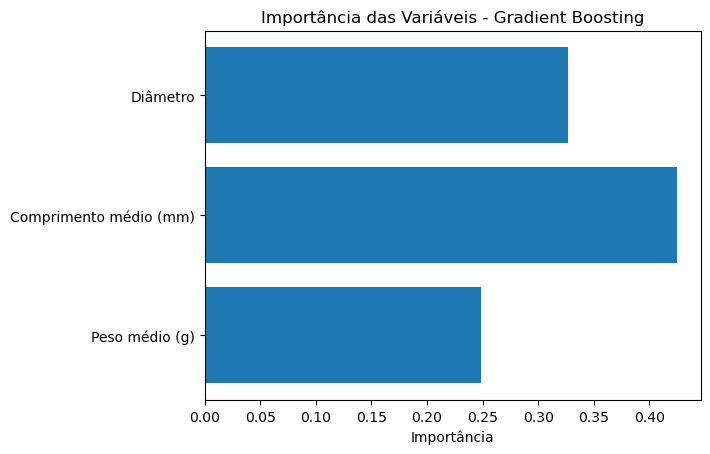

In [31]:
importances = gb_model.feature_importances_

plt.barh(X.columns, importances)
plt.xlabel('Importância')
plt.title('Importância das Variáveis - Gradient Boosting')
plt.show()

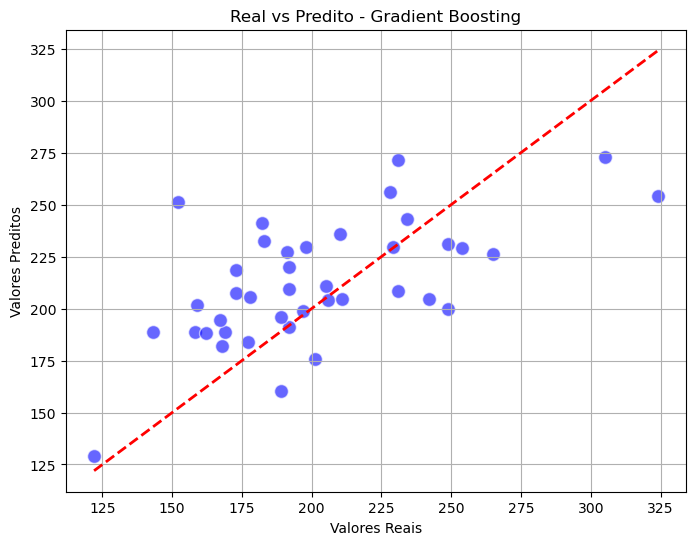

In [32]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_gb, color='blue', alpha=0.6, edgecolors='w', s=100)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2)
plt.title('Real vs Predito - Gradient Boosting')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.grid(True)
plt.show()

#### Scatter plot: 
O gráfico de dispersão mostra como as previsões do modelo (y_pred_gb) se comparam aos valores reais (y_test).

#### Linha vermelha: 
A linha reta (r--) indica a linha de 1:1, ou seja, onde os valores reais seriam iguais aos previstos. Quanto mais próximos os pontos estiverem dessa linha, melhor o desempenho do modelo.